# PS Dispersion measurement + wirescanner

New data from 12 october

- BPMs checked by Jaroen: 70 um resolution at the reference frequency, 150 um at the maximum amplitude
- WS triggered at the end of the frequency drift

**Now using SVD !! (as guido's papers)**

In [1]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.21.1.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/user/e/esenes/Emittance-accuracy-measurement
Your IP is 172.17.0.5
2018-10-18 13:59:53
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


# User inputs

In [2]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.12_dispersion/'

matlabVars = ['PR_SCBFC.Samples.value.samples',
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BPM.AcquisitionMean.value.position',
                'PR_BCT_ST.Samples.value.samples',
                'PA_FREVCL_SD.Samples.value.samples', # Frequency sampler
                'PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1'
            ]

In [3]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))#[:200]
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 300 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.12_dispersion//data/2018.10.12.15.36.33.749.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.12_dispersion//data/2018.10.12.18.27.54.533.mat


In [4]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

# Data cleanup

In [5]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault

No duplicates found
---
BPM data ok
---


# Save the imported data

In [6]:
myDataFrame.to_pickle('imported_data_2018.10.12.pkl')

# Intensity

In [7]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Intensity_max'] = [np.max(x) for x in myDataFrame['Intensity']]
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][900]/x[:][500] )

Text(0,0.5,u'Losses')

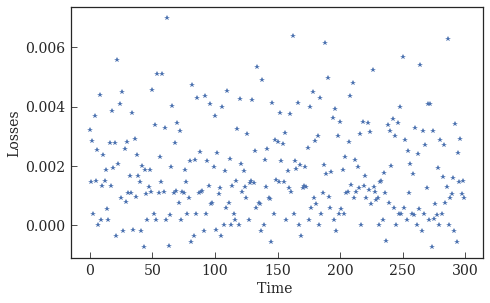

In [8]:
plt.plot(np.linspace(0,len(myDataFrame)-1,len(myDataFrame)),myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

(0, 1000)

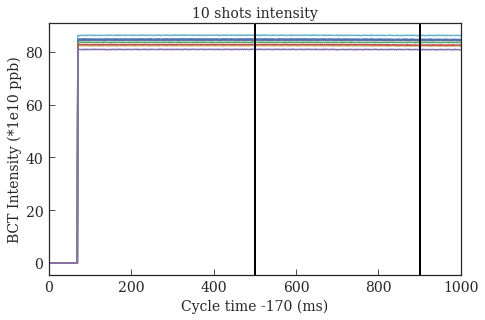

In [9]:
for ll in 40+np.array(range(10)):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=500, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=900, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time -170 (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')
plt.xlim(0,1000)

In [10]:
# drop shots with losses (I still suspect it's just BCT fault)
# myDataFrame = myDataFrame.drop(myDataFrame.loc[myDataFrame['Losses'] > 1].index)

# Calculate dp/p

from the formula 
$$
\frac{dp}{p} = -\frac{1}{\eta}\frac{f - f_0}{f_0}
$$

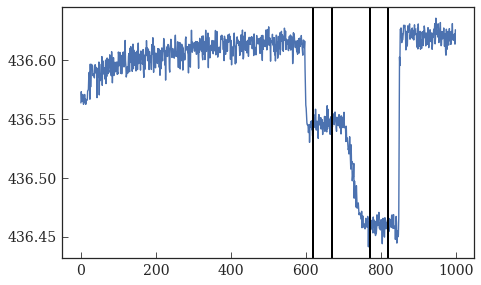

In [11]:
plt.plot(myDataFrame['PA_FREVCL_SD.Samples.value.samples'].iloc[0][:1000])
# f0 averaging interval
plt.axvline(x=620, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=670, ymin=0, ymax = 8, linewidth=2, color='k')
# f averaging interval
plt.axvline(x=770, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=820, ymin=0, ymax = 8, linewidth=2, color='k')

In [12]:
def dpp(f, f0):
    eta = -0.1340054072# from MADx injection7 tunes .21/.24
    return (-1/eta)*(f-f0)/f0

myDataFrame['f0'] = myDataFrame['PA_FREVCL_SD.Samples.value.samples'].apply(lambda x: np.mean(x[620:670]))
myDataFrame['f'] = myDataFrame['PA_FREVCL_SD.Samples.value.samples'].apply(lambda x: np.mean(x[770:820]))
myDataFrame['dpp'] = myDataFrame.apply( lambda row: dpp(row['f'], row['f0']), axis=1)

## Average position at the BPM (in m)

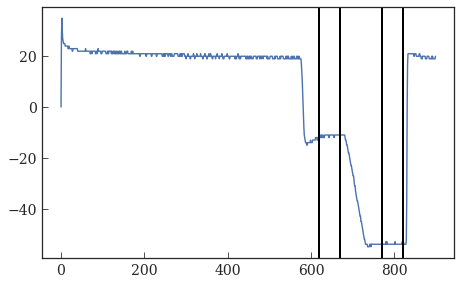

In [13]:
plt.plot(myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].iloc[0][0,0:900])
# averaging interval
plt.axvline(x=770, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=820, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=620, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=670, ymin=0, ymax = 8, linewidth=2, color='k')


In [14]:
myDataFrame['x_bpms_mean'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply( lambda x: 1e-4*(np.mean(x[:,770:820], axis=1)-np.mean(x[:,620:670], axis=1)) )


# SVD

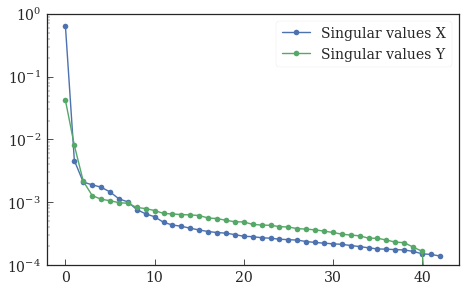

In [15]:
#bulid the matrix
Mx = np.empty([len(myDataFrame),43])
My = np.empty([len(myDataFrame),43])
for k, lab in enumerate(myDataFrame.index):
    Mx[k,:] = myDataFrame['x_bpms_mean'].loc[lab][:43]
    My[k,:] = myDataFrame['x_bpms_mean'].loc[lab][43:]

#now the SVD
u, s, v = np.linalg.svd(Mx)
plt.plot(s,'o-', label="Singular values X")

u, s, v = np.linalg.svd(My)
plt.plot(s,'o-', label="Singular values Y")

ax = plt.gca()
ax.set_yscale('log')
ax.set_ylim(1e-4, 1)
plt.legend(frameon=True)

# Fit the dispersion

In [16]:
from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

D = []
s_D = []

BPMn = 43
xdata = myDataFrame['dpp']
for k in range(BPMn):
    ydata = myDataFrame['x_bpms_mean'].apply(lambda x: x[k])
    popt, pcov = curve_fit(lin, xdata, ydata )
    D.append(popt[1])
    s_D.append(pcov[1][1])
    
    
D = np.array(D, dtype=float)
s_D = np.array(s_D, dtype=float)

Text(0,0.5,u'D_x (m)')

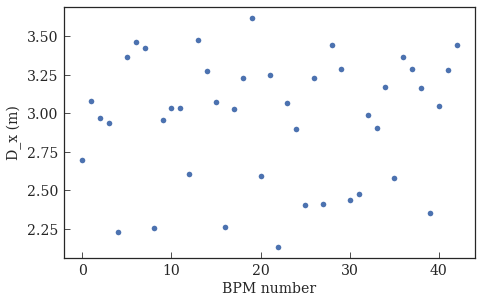

In [17]:
plt.errorbar(np.linspace(0,42,43), D, yerr=s_D, fmt='o')
plt.xlabel('BPM number')
plt.ylabel('D_x (m)' )

# Model-measurement comparison

In [18]:
optics = metaclass.twiss('/eos/user/e/esenes/Emittance-accuracy-measurement/MADx_PFW/madx/ps_6.21_6.24.twiss')
# get the twiss at the BPMs position
optics_names = optics.NAME
BPM_name = []
BPM_idx = []
BPM_Dx = []
BPM_Dy = []

for k in range(len(optics_names)):
    if optics_names[k].find('PR.BPM') != -1:
#        print optics_names[k]
        BPM_name.append(optics_names[k])
        BPM_idx.append(k)
        BPM_Dx.append(optics.DISP1[k])   
        BPM_Dy.append(optics.DISP3[k])

newBPM =  [BPM_name[-1]] + BPM_name[:-1]
BPM_name = newBPM

newBPM =  [BPM_Dx[-1]] + BPM_Dx[:-1]
BPM_Dx = newBPM
        
BPM_S = optics.S[BPM_idx]

In [19]:
# print(BPM_name)
print(BPM_name[28])
print(BPM_Dx[28])
print(D[28])

print(BPM_name[30])
print(BPM_Dx[30])
print(D[30])

PR.BPM65
3.120620278
3.44658452681
PR.BPM68
2.3850069
2.43773189457


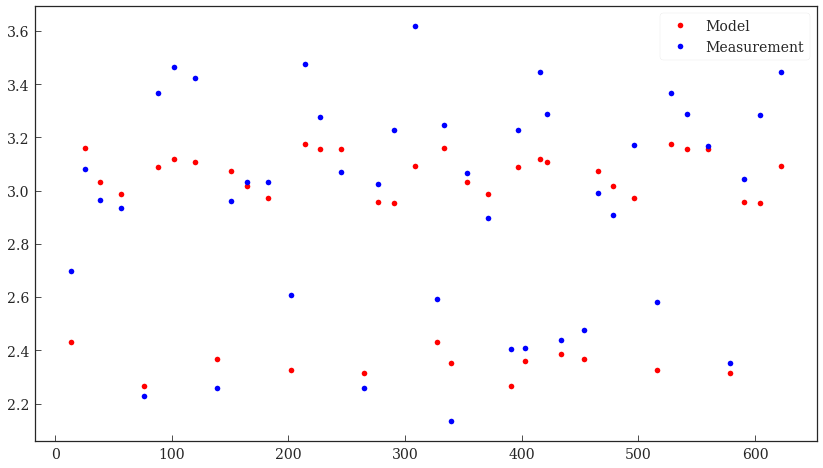

In [20]:
fig, ax = plt.subplots(1,figsize=(14,8))
# ax.plot(optics.S, optics.DISP1,label='Model')
ax.plot(BPM_S, BPM_Dx,'ro', label='Model')
ax.plot(BPM_S, D, 'bo', label='Measurement')
ax.legend(frameon=True)

Text(0.5,0,u'BPM_number')

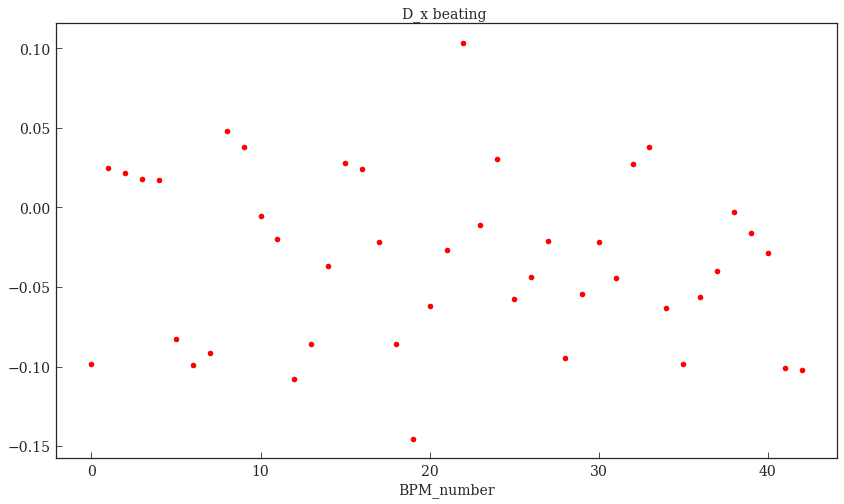

In [21]:
fig, ax = plt.subplots(1,figsize=(14,8))
ax.plot((BPM_Dx-D)/D,'ro', label='Model')
ax.set_title('D_x beating ')
ax.set_xlabel('BPM_number')

Text(0.5,1,u'D_x beating ')

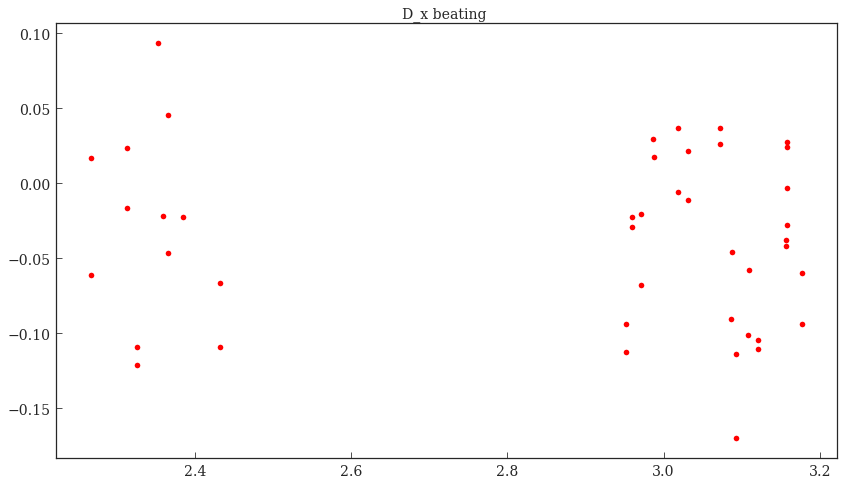

In [22]:
fig, ax = plt.subplots(1,figsize=(14,8))
ax.plot(BPM_Dx,(BPM_Dx-D)/BPM_Dx,'ro', label='Model')
ax.set_title('D_x beating ')


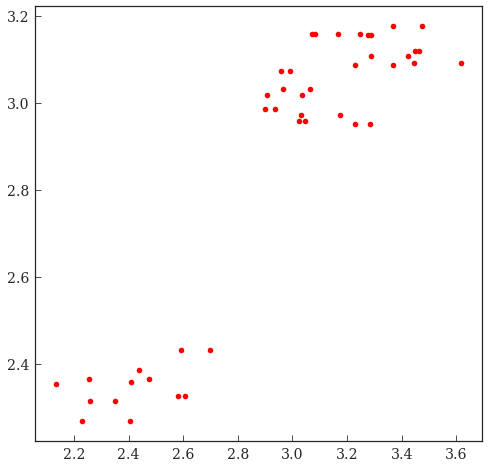

In [23]:
fig, ax = plt.subplots(1,figsize=(8,8))
ax.plot( D, BPM_Dx,'ro', label='Model')


# Data quality plot

(array([ -1.67135694e-04,   3.03434189e+00]), array([  1.67212340e-11,   4.80599141e-06]))


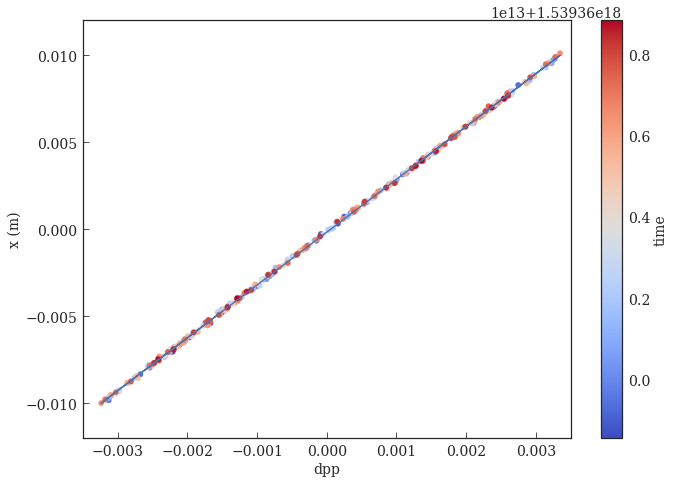

In [24]:
# find correlation parameter 
xx = myDataFrame['dpp']
yy = myDataFrame['x_bpms_mean'].apply(lambda x: x[10])

fig, ax = plt.subplots(1,1,figsize=(10,7))
p1 = ax.scatter(xx, yy, c=myDataFrame.index, cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('time')
ax.set_xlabel('dpp')
ax.set_ylabel('x (m)')

ax.set_xlim(-3.5e-3,3.5e-3)
ax.set_ylim(-12e-3,12e-3)

popt, pcov = curve_fit(lin, xx, yy )
print(popt, np.diag(pcov))
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

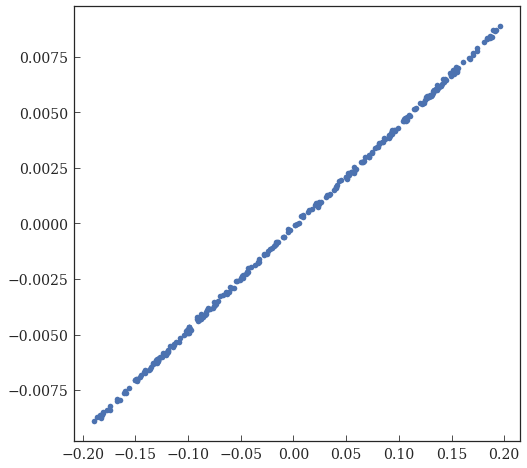

In [25]:
fig, ax = plt.subplots(1,figsize=(8,8))
ax.plot( myDataFrame['f']-myDataFrame['f0'], myDataFrame['x_bpms_mean'].apply(lambda x: x[0]),'o' )


# MRP check

In [26]:
myDataFrame['Xmrp_f'] = myDataFrame['PR_BPM.AcquisitionMean.value.position'].apply(lambda x: np.mean(x[0][770:820]))
myDataFrame['Xmrp_f0'] = myDataFrame['PR_BPM.AcquisitionMean.value.position'].apply(lambda x: np.mean(x[0][620:670]))

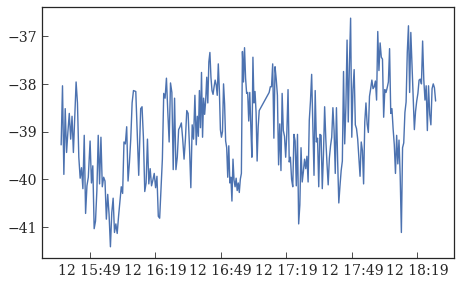

In [27]:
# plt.plot(myDataFrame['Xmrp_f0'].loc[(myDataFrame['Xmrp_f0']<-10) & (myDataFrame['Xmrp_f0']>-17)])
plt.plot(myDataFrame['Xmrp_f0'])

# Wirescanner check

In [28]:
# pull the wirescanner data from TIMBER
ts1 = '2018-10-12 15:36:00.000'
ts2 = '2018-10-12 18:27:20.000'

PSuser = 'CPS:MD4404_BCMS:MD5'

WS_variables = ['PR.BWS.65.H_ROT:PROF_POSITION_IN', 'PR.BWS.65.H_ROT:PROF_DATA_IN','PR.BWS.85.V_ROT:PROF_POSITION_IN', 'PR.BWS.85.V_ROT:PROF_DATA_IN']

myToolbox.addToDataFrameFromCALS(myDataFrame, WS_variables)

In [29]:
# manual dropping WS acquisition faults
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-12 15:37:16.300000'].name) # X wirescanner fault
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-12 17:11:10.300000'].name) # X wirescanner fault
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-12 15:36:39.100000'].name) # Y wirescanner fault

# renaming variables to match legacy code
myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'] = myDataFrame['PR.BWS.65.H_ROT:PROF_POSITION_IN']
myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'] = myDataFrame['PR.BWS.65.H_ROT:PROF_DATA_IN']
myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'] = myDataFrame['PR.BWS.85.V_ROT:PROF_POSITION_IN']
myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'] = myDataFrame['PR.BWS.85.V_ROT:PROF_DATA_IN']

myDataFrame = myDataFrame.drop(['PR.BWS.65.H_ROT:PROF_POSITION_IN','PR.BWS.65.H_ROT:PROF_DATA_IN','PR.BWS.85.V_ROT:PROF_POSITION_IN','PR.BWS.85.V_ROT:PROF_DATA_IN'], axis=1)


In [30]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
        
#do the fit and get the sigma in mm
myDataFrame['WS65_fit_results'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS65_sigma'] = myDataFrame['WS65_fit_results'].apply(lambda x: x[0][-1])
myDataFrame['WS65_mean'] = myDataFrame['WS65_fit_results'].apply(lambda x: x[0][-2])

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(array([ 7.37566459,  1.07514694]), array([  6.47405554e-04,   7.80545496e-06]))


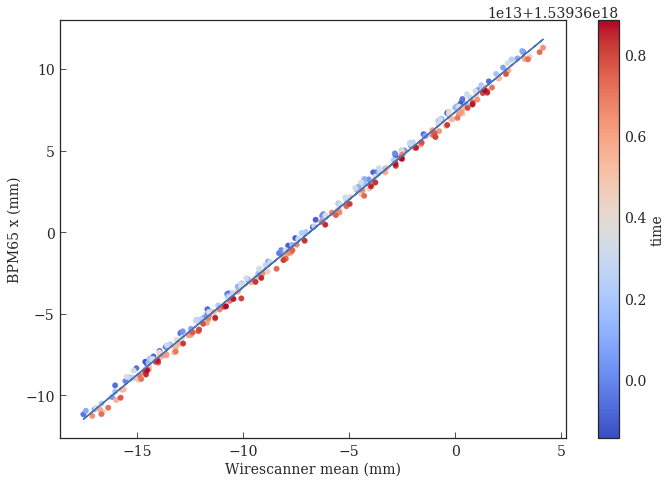

In [31]:
# BPM65 - BWS65 agreement plot
xx = myDataFrame['WS65_mean']
yy = 1e3*myDataFrame['x_bpms_mean'].apply(lambda x: x[28])

fig, ax = plt.subplots(1,1,figsize=(10,7))
p1 = ax.scatter(xx, yy, c=myDataFrame.index, cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('time')
ax.set_xlabel('Wirescanner mean (mm)')
ax.set_ylabel('BPM65 x (mm)')

popt, pcov = curve_fit(lin, xx, yy )
print(popt, np.diag(pcov))
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

Disperison measured with the wirescanner: 	 D = 3.19974720915 +/- 7.00779745291e-05 m
Model dispersion: 				 D = 3.121050838 m


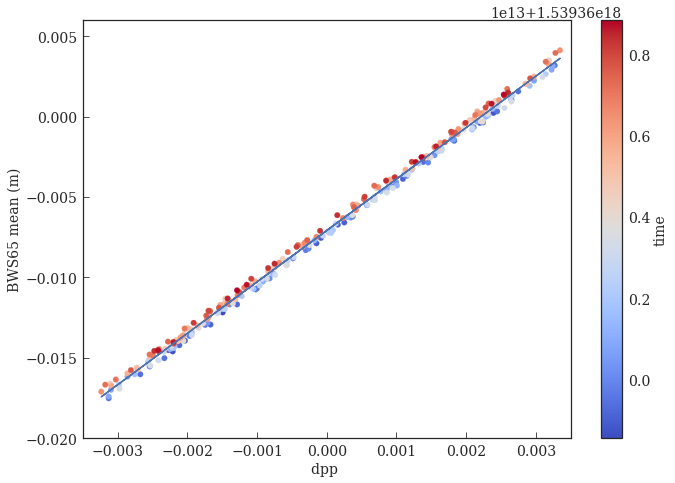

In [32]:
# Dispersion measurement
xx = myDataFrame['dpp']
yy = 1e-3*myDataFrame['WS65_mean']

fig, ax = plt.subplots(1,1,figsize=(10,7))
p1 = ax.scatter(xx, yy, c=myDataFrame.index, cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('time')
ax.set_xlabel('dpp ')
ax.set_ylabel('BWS65 mean (m)')

ax.set_xlim(-3.5e-3,3.5e-3)
ax.set_ylim(-20e-3,6e-3)

popt, pcov = curve_fit(lin, xx, yy )
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

print('Disperison measured with the wirescanner: \t D = '+str(popt[1])+' +/- '+str(pcov[1][1]) + ' m')
print('Model dispersion: \t\t\t\t D = '+str(optics.DISP1[1716])+ ' m')